# 🧬 Biological Graph Learning: Protein-Protein Interactions

In this notebook, we apply Graph Neural Networks to a challenging biological task: **Protein-Protein Interaction (PPI)** prediction.

### The Task
The PPI dataset consists of graphs where:
- **Nodes** are proteins.
- **Edges** represent physical interactions between proteins.
- **Node Features** include positional gene sets, motif gene sets, and immunological signatures.
- **Labels** are biological functions (Gene Ontology terms). This is a **multi-label classification** problem (a protein can have multiple functions).

Unlike citation networks (Cora), PPI involves **inductive learning**: we train on 20 graphs and test on 2 completely unseen graphs. This tests the model's ability to generalize to new biological networks.

In [1]:
import sys
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt

# Add project root to path to allow importing src
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    sys.path.append(str(current_dir.parent))
else:
    sys.path.append(str(current_dir))

from src.training import Trainer, TrainerConfig
from src.models import GCN, GAT

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

c:\Users\arbio\anaconda3\envs\ml-timeseries\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## 🧪 Experiment 1: GCN Baseline

We start by training a robust GCN model. Since PPI is a larger and more complex dataset than Cora, we use:
- **3 Layers**: To capture larger neighborhoods.
- **256 Hidden Units**: For higher capacity.
- **Skip Connections & Layer Norm**: Essential for training deeper GCNs on dense graphs like PPI.

In [7]:
config_gcn = TrainerConfig(
    dataset_name="ppi",
    batch_size=2,  # PPI graphs are large, so we use a small batch size
    hidden_dim=256,
    num_layers=3,
    dropout=0.2,
    lr=0.005,
    n_epochs=40,
    use_skip_connections=True,
    use_graph_norm=True,
    device=device
)

print("Training GCN on PPI...")
trainer_gcn = Trainer(config=config_gcn)
metrics_gcn = trainer_gcn.train()

INFO:src.training.trainer:Initialized trainer for ppi
INFO:src.training.trainer:Model: 339954 parameters


Training GCN on PPI...


Epoch 40 | Loss: 0.3744 | Val Acc: 0.8469 | LR: 5.00e-03 | Smooth: 0.000: 100%|██████████| 40/40 [03:25<00:00,  5.15s/it]
INFO:src.training.trainer:Restored best model with val_acc=0.8469


## ⚔️ Experiment 2: GCN vs GAT

Graph Attention Networks (GAT) were originally demonstrated to outperform GCNs on the PPI dataset. The attention mechanism allows the model to weigh the importance of different protein interactions dynamically.

We train a GAT model with **4 attention heads** to compare.

In [8]:
config_gat = TrainerConfig(
    dataset_name="ppi",
    batch_size=2,
    hidden_dim=256,
    num_layers=3,
    dropout=0.2,
    lr=0.005,
    n_epochs=40,
    device=device
)

print("\nTraining GAT on PPI...")
trainer_gat = Trainer(config=config_gat)

# Manually swap to GAT model
# We use 4 heads, so hidden_dim per head = 256 / 4 = 64
trainer_gat.model = GAT(
    input_dim=trainer_gat.data_handler.num_features,
    hidden_dim=64,
    output_dim=trainer_gat.data_handler.num_classes,
    num_layers=3,
    heads=4,
    dropout=0.2
).to(device)

# Rebuild optimizer to track new model parameters
trainer_gat.optimizer = trainer_gat._build_optimizer()

metrics_gat = trainer_gat.train()

INFO:src.training.trainer:Initialized trainer for ppi
INFO:src.training.trainer:Model: 338418 parameters



Training GAT on PPI...


Epoch 40 | Loss: 0.3977 | Val Acc: 0.8393 | LR: 5.00e-03: 100%|██████████| 40/40 [03:43<00:00,  5.59s/it]
INFO:src.training.trainer:Restored best model with val_acc=0.8397


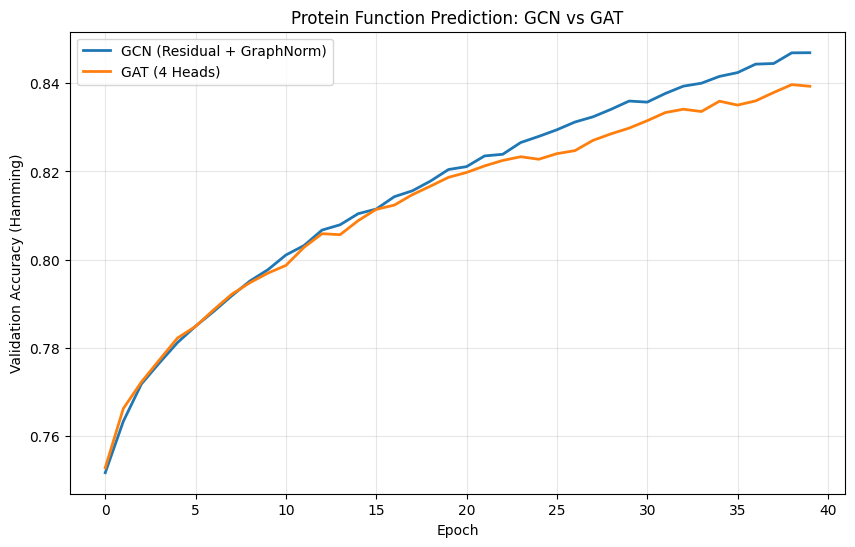

In [11]:
# Compare Results
plt.figure(figsize=(10, 6))
plt.plot(metrics_gcn.history["val_acc"], label="GCN (Residual + GraphNorm)", linewidth=2)
plt.plot(metrics_gat.history["val_acc"], label="GAT (4 Heads)", linewidth=2)
plt.title("Protein Function Prediction: GCN vs GAT")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (Hamming)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🧠 Experiment 3: The Importance of Modern Architecture

Biological networks are often dense and exhibit different structural properties than social or citation networks. We investigate how much **Skip Connections** and **Graph Normalization** contribute to the GCN's performance on this task.

INFO:src.training.trainer:Initialized trainer for ppi
INFO:src.training.trainer:Model: 206834 parameters



Training Plain GCN (No Skip/Norm)...


Epoch 40 | Loss: 0.4121 | Val Acc: 0.8237 | LR: 5.00e-03 | Smooth: 0.000: 100%|██████████| 40/40 [02:02<00:00,  3.07s/it]
INFO:src.training.trainer:Restored best model with val_acc=0.8237


Plain GCN - Test Acc: 0.8283, Best Val Acc: 0.8237
Enhanced GCN - Test Acc: 0.8545, Best Val Acc: 0.8469


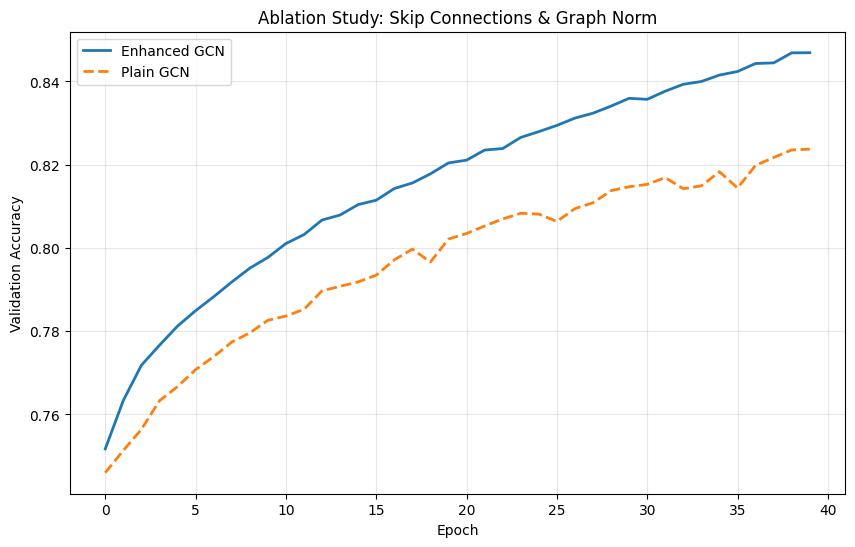

In [17]:
config_plain = TrainerConfig(
    dataset_name="ppi",
    batch_size=2,
    hidden_dim=256,
    num_layers=3,
    dropout=0.2,
    lr=0.005,
    n_epochs=40,
    use_skip_connections=False,
    use_graph_norm=False,
    device=device
)

print("\nTraining Plain GCN (No Skip/Norm)...")
trainer_plain = Trainer(config=config_plain)
metrics_plain = trainer_plain.train()

plain_test_acc = trainer_plain.evaluate(split="test")[1]
gcn_test_acc = trainer_gcn.evaluate(split="test")[1]

print(f"Plain GCN - Test Acc: {plain_test_acc:.4f}, Best Val Acc: {trainer_plain.best_val_acc:.4f}")
print(f"Enhanced GCN - Test Acc: {gcn_test_acc:.4f}, Best Val Acc: {trainer_gcn.best_val_acc:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(metrics_gcn.history["val_acc"], label="Enhanced GCN", linewidth=2)
plt.plot(metrics_plain.history["val_acc"], label="Plain GCN", linewidth=2, linestyle="--")
plt.title("Ablation Study: Skip Connections & Graph Norm")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()